<a href="https://colab.research.google.com/github/sduvvur7/DL/blob/main/DL4_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
dev = qml.device("default.qubit", wires=2)

In [ ]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline

In [61]:
!pip install pennylane
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Ansatz -1

In [193]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

In [63]:
def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

In [64]:
def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

In [194]:
dev = qml.device("default.qubit", wires=5)

In [195]:
def get_angles(x):

    beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
    beta1 = 2 * np.arcsin(np.sqrt(x[3] ** 2) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
    beta2 = 2 * np.arcsin(
        np.sqrt(x[2] ** 2 + x[3] ** 2)
        / np.sqrt(x[0] ** 2 + x[1] ** 2 + x[2] ** 2 + x[3] ** 2)
    )

    return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])


def statepreparation(a):
    qml.RY(a[0], wires=0)

    qml.CNOT(wires=[0, 1])
    qml.RY(a[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[2], wires=1)

    qml.PauliX(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[3], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[4], wires=1)
    qml.PauliX(wires=0)

In [ ]:
x = np.array([0.53896774, 0.79503606, 0.27826503, 0.0], requires_grad=False)
ang = get_angles(x)


@qml.qnode(dev)
def test(angles):

    statepreparation(angles)

    return qml.expval(qml.PauliZ(0))


test(ang)

print("x               : ", x)
print("angles          : ", ang)
print("amplitude vector: ", np.real(dev.state))

In [197]:
def layer(W):
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.Rot(W[2, 0], W[2, 1], W[2, 2], wires=2)
    qml.Rot(W[3, 0], W[3, 1], W[3, 2], wires=3)
    qml.Rot(W[4, 0], W[4, 1], W[4, 2], wires=4)
    qml.CNOT(wires=[0,1])
    qml.CNOT(wires=[0, 1])
    qml.PauliX(0)


In [198]:
@qml.qnode(dev)
def circuit(weights, angles):
    statepreparation(angles)

    for W in weights:
        layer(W)

    return qml.expval(qml.PauliZ(0))


def variational_classifier(weights, bias, angles):
    return circuit(weights, angles) + bias


def cost(weights, bias, features, labels):
    predictions = [variational_classifier(weights, bias, f) for f in features]
    return square_loss(labels, predictions)

In [199]:
from dataclasses import dataclass
from google.colab import files
import pandas as pd
import io
uploaded = files.upload()
data = pd.read_csv(io.BytesIO(uploaded['Iris.csv']))

#Y dataset
Y=data['Species'][0:100]

#one hot encoding
for i in range(100):
    if (Y[i]=="Iris-setosa"):
      Y[i]=-1
    else:
      Y[i]=1


Y=Y.to_numpy()

#X dataset
X=data
X.drop(columns=['Id', 'Species'], axis=1,inplace=True)
X=X[0:100]
X=X.to_numpy()


# normalize each input
normalization = np.sqrt(np.sum(X ** 2, -1))
X_norm = (X.T / normalization).T
print("First X sample (normalized):", X_norm[0])

# angles for state preparation are new features
features = np.array([get_angles(x) for x in X_norm], requires_grad=False)
print("First features sample      :", features[0])

Saving Iris.csv to Iris (15).csv
First X sample (normalized): [0.80377277 0.55160877 0.22064351 0.0315205 ]
First features sample      : [ 0.44954297 -0.14189705  0.14189705 -0.60145471  0.60145471]


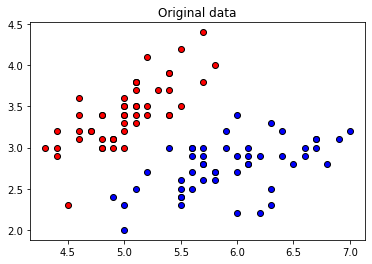

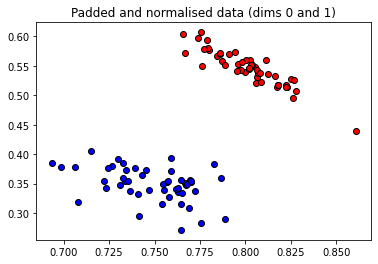

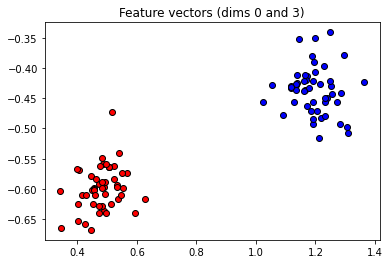

In [200]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(X[:, 0][Y == 1], X[:, 1][Y == 1], c="b", marker="o", edgecolors="k")
plt.scatter(X[:, 0][Y == -1], X[:, 1][Y == -1], c="r", marker="o", edgecolors="k")
plt.title("Original data")
plt.show()

plt.figure()
dim1 = 0
dim2 = 1
plt.scatter(
    X_norm[:, dim1][Y == 1], X_norm[:, dim2][Y == 1], c="b", marker="o", edgecolors="k"
)
plt.scatter(
    X_norm[:, dim1][Y == -1], X_norm[:, dim2][Y == -1], c="r", marker="o", edgecolors="k"
)
plt.title("Padded and normalised data (dims {} and {})".format(dim1, dim2))
plt.show()

plt.figure()
dim1 = 0
dim2 = 3
plt.scatter(
    features[:, dim1][Y == 1], features[:, dim2][Y == 1], c="b", marker="o", edgecolors="k"
)
plt.scatter(
    features[:, dim1][Y == -1], features[:, dim2][Y == -1], c="r", marker="o", edgecolors="k"
)
plt.title("Feature vectors (dims {} and {})".format(dim1, dim2))
plt.show()

In [201]:
np.random.seed(0)
num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
feats_train = features[index[:num_train]]
Y_train = Y[index[:num_train]]
feats_val = features[index[num_train:]]
Y_val = Y[index[num_train:]]

# We need these later for plotting
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]

In [206]:
num_qubits = 5
num_layers = 6

weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

In [207]:
opt = NesterovMomentumOptimizer(0.01)
batch_size = 5

# train the variational classifier
weights = weights_init
bias = bias_init
for it in range(40):

    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, feats_train_batch, Y_train_batch)

    # Compute predictions on train and validation set
    predictions_train = [np.sign(variational_classifier(weights, bias, f)) for f in feats_train]
    predictions_val = [np.sign(variational_classifier(weights, bias, f)) for f in feats_val]

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
        "".format(it + 1, cost(weights, bias, features, Y), acc_train, acc_val)
    )

Iter:     1 | Cost: 1.9294443 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     2 | Cost: 1.9084432 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     3 | Cost: 1.8878095 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     4 | Cost: 1.8411960 | Acc train: 0.4800000 | Acc validation: 0.5200000 
Iter:     5 | Cost: 1.7967941 | Acc train: 0.1200000 | Acc validation: 0.1200000 
Iter:     6 | Cost: 1.7826592 | Acc train: 0.0000000 | Acc validation: 0.0000000 
Iter:     7 | Cost: 1.8078654 | Acc train: 0.0000000 | Acc validation: 0.0000000 
Iter:     8 | Cost: 1.8395202 | Acc train: 0.0000000 | Acc validation: 0.0000000 
Iter:     9 | Cost: 1.8801664 | Acc train: 0.0000000 | Acc validation: 0.0000000 
Iter:    10 | Cost: 1.9194925 | Acc train: 0.0400000 | Acc validation: 0.0400000 
Iter:    11 | Cost: 1.9496380 | Acc train: 0.1466667 | Acc validation: 0.1200000 
Iter:    12 | Cost: 1.8616626 | Acc train: 0.0000000 | Acc validation: 0.0000000 
Iter:    13 | Co

### ANSATZ - 2

In [212]:
dev = qml.device("default.qubit", wires=2)

In [213]:
def get_angles(x):

    beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
    beta1 = 2 * np.arcsin(np.sqrt(x[3] ** 2) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
    beta2 = 2 * np.arcsin(
        np.sqrt(x[2] ** 2 + x[3] ** 2)
        / np.sqrt(x[0] ** 2 + x[1] ** 2 + x[2] ** 2 + x[3] ** 2)
    )

    return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])


def statepreparation(a):
    qml.RY(a[0], wires=0)

    qml.CNOT(wires=[0, 1])
    qml.RY(a[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[2], wires=1)

    qml.PauliX(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[3], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[4], wires=1)
    qml.PauliX(wires=0)

In [215]:
def layer(W):
    qml.CNOT(wires=[0,1])
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[0,1])
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[0,1])
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[0,1])
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[0,1])
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[0,1])
    qml.CNOT(wires=[0, 1])
    qml.PauliX(0)


In [216]:
@qml.qnode(dev)
def circuit(weights, angles):
    statepreparation(angles)

    for W in weights:
        layer(W)

    return qml.expval(qml.PauliZ(0))


def variational_classifier(weights, bias, angles):
    return circuit(weights, angles) + bias


def cost(weights, bias, features, labels):
    predictions = [variational_classifier(weights, bias, f) for f in features]
    return square_loss(labels, predictions)

In [217]:
from dataclasses import dataclass
from google.colab import files
import pandas as pd
import io
uploaded = files.upload()
data = pd.read_csv(io.BytesIO(uploaded['Iris.csv']))

#Y dataset
Y=data['Species'][0:100]

#one hot encoding
for i in range(100):
    if (Y[i]=="Iris-setosa"):
      Y[i]=-1
    else:
      Y[i]=1


Y=Y.to_numpy()

#X dataset
X=data
X.drop(columns=['Id', 'Species'], axis=1,inplace=True)
X=X[0:100]
X=X.to_numpy()


# normalize each input
normalization = np.sqrt(np.sum(X ** 2, -1))
X_norm = (X.T / normalization).T
print("First X sample (normalized):", X_norm[0])

# angles for state preparation are new features
features = np.array([get_angles(x) for x in X_norm], requires_grad=False)
print("First features sample      :", features[0])

Saving Iris.csv to Iris (16).csv
First X sample (normalized): [0.80377277 0.55160877 0.22064351 0.0315205 ]
First features sample      : [ 0.44954297 -0.14189705  0.14189705 -0.60145471  0.60145471]


In [219]:
np.random.seed(0)
num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
feats_train = features[index[:num_train]]
Y_train = Y[index[:num_train]]
feats_val = features[index[num_train:]]
Y_val = Y[index[num_train:]]

# We need these later for plotting
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]

In [220]:
num_qubits = 2
num_layers = 6

weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

In [221]:
opt = NesterovMomentumOptimizer(0.01)
batch_size = 5

# train the variational classifier
weights = weights_init
bias = bias_init
for it in range(40):

    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, feats_train_batch, Y_train_batch)

    # Compute predictions on train and validation set
    predictions_train = [np.sign(variational_classifier(weights, bias, f)) for f in feats_train]
    predictions_val = [np.sign(variational_classifier(weights, bias, f)) for f in feats_val]

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
        "".format(it + 1, cost(weights, bias, features, Y), acc_train, acc_val)
    )

Iter:     1 | Cost: 1.9561223 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     2 | Cost: 1.9176472 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     3 | Cost: 1.8570296 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     4 | Cost: 1.7850261 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     5 | Cost: 1.7278055 | Acc train: 0.4800000 | Acc validation: 0.5200000 
Iter:     6 | Cost: 1.6842953 | Acc train: 0.4133333 | Acc validation: 0.4400000 
Iter:     7 | Cost: 1.6520764 | Acc train: 0.2666667 | Acc validation: 0.2800000 
Iter:     8 | Cost: 1.6329842 | Acc train: 0.1333333 | Acc validation: 0.1200000 
Iter:     9 | Cost: 1.6122960 | Acc train: 0.0266667 | Acc validation: 0.0000000 
Iter:    10 | Cost: 1.6019036 | Acc train: 0.0133333 | Acc validation: 0.0000000 
Iter:    11 | Cost: 1.5973858 | Acc train: 0.0000000 | Acc validation: 0.0000000 
Iter:    12 | Cost: 1.5987501 | Acc train: 0.0133333 | Acc validation: 0.0000000 
Iter:    13 | Co

### ANSATZ - 3

In [223]:
dev = qml.device("default.qubit", wires=2)

In [224]:
def get_angles(x):

    beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
    beta1 = 2 * np.arcsin(np.sqrt(x[3] ** 2) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
    beta2 = 2 * np.arcsin(
        np.sqrt(x[2] ** 2 + x[3] ** 2)
        / np.sqrt(x[0] ** 2 + x[1] ** 2 + x[2] ** 2 + x[3] ** 2)
    )

    return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])


def statepreparation(a):
    qml.RY(a[0], wires=0)

    qml.CNOT(wires=[0, 1])
    qml.RY(a[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[2], wires=1)

    qml.PauliX(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[3], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[4], wires=1)
    qml.PauliX(wires=0)

In [225]:
def layer(W):
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
  


In [226]:
@qml.qnode(dev)
def circuit(weights, angles):
    statepreparation(angles)

    for W in weights:
        layer(W)

    return qml.expval(qml.PauliZ(0))


def variational_classifier(weights, bias, angles):
    return circuit(weights, angles) + bias


def cost(weights, bias, features, labels):
    predictions = [variational_classifier(weights, bias, f) for f in features]
    return square_loss(labels, predictions)

In [227]:
from dataclasses import dataclass
from google.colab import files
import pandas as pd
import io
uploaded = files.upload()
data = pd.read_csv(io.BytesIO(uploaded['Iris.csv']))

#Y dataset
Y=data['Species'][0:100]

#one hot encoding
for i in range(100):
    if (Y[i]=="Iris-setosa"):
      Y[i]=-1
    else:
      Y[i]=1


Y=Y.to_numpy()

#X dataset
X=data
X.drop(columns=['Id', 'Species'], axis=1,inplace=True)
X=X[0:100]
X=X.to_numpy()


# normalize each input
normalization = np.sqrt(np.sum(X ** 2, -1))
X_norm = (X.T / normalization).T
print("First X sample (normalized):", X_norm[0])

# angles for state preparation are new features
features = np.array([get_angles(x) for x in X_norm], requires_grad=False)
print("First features sample      :", features[0])

Saving Iris.csv to Iris (17).csv
First X sample (normalized): [0.80377277 0.55160877 0.22064351 0.0315205 ]
First features sample      : [ 0.44954297 -0.14189705  0.14189705 -0.60145471  0.60145471]


In [228]:
np.random.seed(0)
num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
feats_train = features[index[:num_train]]
Y_train = Y[index[:num_train]]
feats_val = features[index[num_train:]]
Y_val = Y[index[num_train:]]

# We need these later for plotting
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]

In [229]:
num_qubits = 2
num_layers = 6

weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

In [230]:
opt = NesterovMomentumOptimizer(0.01)
batch_size = 5

# train the variational classifier
weights = weights_init
bias = bias_init
for it in range(40):

    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, feats_train_batch, Y_train_batch)

    # Compute predictions on train and validation set
    predictions_train = [np.sign(variational_classifier(weights, bias, f)) for f in feats_train]
    predictions_val = [np.sign(variational_classifier(weights, bias, f)) for f in feats_val]

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
        "".format(it + 1, cost(weights, bias, features, Y), acc_train, acc_val)
    )

Iter:     1 | Cost: 1.8529755 | Acc train: 0.0133333 | Acc validation: 0.0000000 
Iter:     2 | Cost: 0.7429334 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     3 | Cost: 1.4785378 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     4 | Cost: 0.7872470 | Acc train: 0.5200000 | Acc validation: 0.4400000 
Iter:     5 | Cost: 1.3388995 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     6 | Cost: 1.0522156 | Acc train: 0.5200000 | Acc validation: 0.4400000 
Iter:     7 | Cost: 0.6767697 | Acc train: 0.5333333 | Acc validation: 0.6000000 
Iter:     8 | Cost: 1.1537481 | Acc train: 0.5200000 | Acc validation: 0.4400000 
Iter:     9 | Cost: 2.0114136 | Acc train: 0.5200000 | Acc validation: 0.4400000 
Iter:    10 | Cost: 2.0164986 | Acc train: 0.5200000 | Acc validation: 0.4400000 
Iter:    11 | Cost: 0.7642451 | Acc train: 0.5200000 | Acc validation: 0.4400000 
Iter:    12 | Cost: 1.0394237 | Acc train: 0.5200000 | Acc validation: 0.4400000 
Iter:    13 | Co

ROTATIONAL for X encoding

In [102]:
dev = qml.device("default.qubit", wires=4)

In [103]:
def get_angles(x):

    beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
    beta1 = 2 * np.arcsin(np.sqrt(x[3] ** 2) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
    beta2 = 2 * np.arcsin(
        np.sqrt(x[2] ** 2 + x[3] ** 2)
        / np.sqrt(x[0] ** 2 + x[1] ** 2 + x[2] ** 2 + x[3] ** 2)
    )

    return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])


def statepreparation(a):
    for i in range(4):
      qml.RX(a[i],wires=i)
      

In [104]:
x = np.array([0.53896774, 0.79503606, 0.27826503, 0.0], requires_grad=False)
ang = get_angles(x)


@qml.qnode(dev)
def test(angles):

    statepreparation(angles)

    return qml.expval(qml.PauliZ(0))


test(ang)

print("x               : ", x)
print("angles          : ", ang)
print("amplitude vector: ", np.real(dev.state))

x               :  [0.53896774 0.79503606 0.27826503 0.        ]
angles          :  [ 0.56397465 -0.          0.         -0.97504604  0.97504604]
amplitude vector:  [0.84860162 0.         0.         0.         0.         0.
 0.         0.         0.         0.13035017 0.         0.
 0.         0.         0.         0.        ]


In [105]:
def layer(W):
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.CNOT(wires=[0, 1])

In [106]:
@qml.qnode(dev)
def circuit(weights, angles):
    statepreparation(angles)

    for W in weights:
        layer(W)

    return qml.expval(qml.PauliZ(0))


def variational_classifier(weights, bias, angles):
    return circuit(weights, angles) + bias


def cost(weights, bias, features, labels):
    predictions = [variational_classifier(weights, bias, f) for f in features]
    return square_loss(labels, predictions)

In [107]:
from dataclasses import dataclass
from google.colab import files
import pandas as pd
import io
uploaded = files.upload()
data = pd.read_csv(io.BytesIO(uploaded['Iris.csv']))

#Y dataset
Y=data['Species'][0:100]

#one hot encoding
for i in range(100):
    if (Y[i]=="Iris-setosa"):
      Y[i]=-1
    else:
      Y[i]=1


Y=Y.to_numpy()

#X dataset
X=data
X.drop(columns=['Id', 'Species'], axis=1,inplace=True)
X=X[0:100]
X=X.to_numpy()


# normalize each input
normalization = np.sqrt(np.sum(X ** 2, -1))
X_norm = (X.T / normalization).T
print("First X sample (normalized):", X_norm[0])

# angles for state preparation are new features
features = np.array([get_angles(x) for x in X_norm], requires_grad=False)
print("First features sample      :", features[0])

Saving Iris.csv to Iris (6).csv
First X sample (normalized): [0.80377277 0.55160877 0.22064351 0.0315205 ]
First features sample      : [ 0.44954297 -0.14189705  0.14189705 -0.60145471  0.60145471]


In [108]:
np.random.seed(0)
num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
feats_train = features[index[:num_train]]
Y_train = Y[index[:num_train]]
feats_val = features[index[num_train:]]
Y_val = Y[index[num_train:]]

# We need these later for plotting
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]

In [109]:
num_qubits = 4
num_layers = 6

weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

In [110]:
opt = NesterovMomentumOptimizer(0.01)
batch_size = 5

# train the variational classifier
weights = weights_init
bias = bias_init
for it in range(60):

    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, feats_train_batch, Y_train_batch)

    # Compute predictions on train and validation set
    predictions_train = [np.sign(variational_classifier(weights, bias, f)) for f in feats_train]
    predictions_val = [np.sign(variational_classifier(weights, bias, f)) for f in feats_val]

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
        "".format(it + 1, cost(weights, bias, features, Y), acc_train, acc_val)
    )

Iter:     1 | Cost: 1.9560462 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     2 | Cost: 1.9291452 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     3 | Cost: 1.9214909 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     4 | Cost: 1.9190954 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     5 | Cost: 1.9093400 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     6 | Cost: 1.8935625 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     7 | Cost: 1.8730380 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     8 | Cost: 1.8496887 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     9 | Cost: 1.7953182 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:    10 | Cost: 1.7574741 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:    11 | Cost: 1.7166211 | Acc train: 0.4800000 | Acc validation: 0.5200000 
Iter:    12 | Cost: 1.6758821 | Acc train: 0.4133333 | Acc validation: 0.4400000 
Iter:    13 | Co

ROTATION FOR Y----- Y AXIS




In [111]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

In [112]:
def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

In [113]:
def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

In [114]:
dev = qml.device("default.qubit", wires=4)

In [115]:
def get_angles(x):

    beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
    beta1 = 2 * np.arcsin(np.sqrt(x[3] ** 2) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
    beta2 = 2 * np.arcsin(
        np.sqrt(x[2] ** 2 + x[3] ** 2)
        / np.sqrt(x[0] ** 2 + x[1] ** 2 + x[2] ** 2 + x[3] ** 2)
    )

    return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])


def statepreparation(a):
    for i in range(4):
      qml.RY(a[i],wires=i)

In [116]:
x = np.array([0.53896774, 0.79503606, 0.27826503, 0.0], requires_grad=False)
ang = get_angles(x)


@qml.qnode(dev)
def test(angles):

    statepreparation(angles)

    return qml.expval(qml.PauliZ(0))


test(ang)

print("x               : ", x)
print("angles          : ", ang)
print("amplitude vector: ", np.real(dev.state))

x               :  [0.53896774 0.79503606 0.27826503 0.        ]
angles          :  [ 0.56397465 -0.          0.         -0.97504604  0.97504604]
amplitude vector:  [ 0.84860162 -0.44993762  0.          0.          0.          0.
  0.          0.          0.24584601 -0.13035017  0.          0.
  0.          0.          0.          0.        ]


In [117]:
def layer(W):
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.CNOT(wires=[0, 1])

In [118]:
@qml.qnode(dev)
def circuit(weights, angles):
    statepreparation(angles)

    for W in weights:
        layer(W)

    return qml.expval(qml.PauliZ(0))


def variational_classifier(weights, bias, angles):
    return circuit(weights, angles) + bias


def cost(weights, bias, features, labels):
    predictions = [variational_classifier(weights, bias, f) for f in features]
    return square_loss(labels, predictions)

In [119]:
from dataclasses import dataclass
from google.colab import files
import pandas as pd
import io
uploaded = files.upload()
data = pd.read_csv(io.BytesIO(uploaded['Iris.csv']))

#Y dataset
Y=data['Species'][0:100]

#one hot encoding
for i in range(100):
    if (Y[i]=="Iris-setosa"):
      Y[i]=-1
    else:
      Y[i]=1


Y=Y.to_numpy()

#X dataset
X=data
X.drop(columns=['Id', 'Species'], axis=1,inplace=True)
X=X[0:100]
X=X.to_numpy()


# normalize each input
normalization = np.sqrt(np.sum(X ** 2, -1))
X_norm = (X.T / normalization).T
print("First X sample (normalized):", X_norm[0])

# angles for state preparation are new features
features = np.array([get_angles(x) for x in X_norm], requires_grad=False)
print("First features sample      :", features[0])

Saving Iris.csv to Iris (7).csv
First X sample (normalized): [0.80377277 0.55160877 0.22064351 0.0315205 ]
First features sample      : [ 0.44954297 -0.14189705  0.14189705 -0.60145471  0.60145471]


In [120]:
np.random.seed(0)
num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
feats_train = features[index[:num_train]]
Y_train = Y[index[:num_train]]
feats_val = features[index[num_train:]]
Y_val = Y[index[num_train:]]

# We need these later for plotting
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]

In [121]:
num_qubits = 4
num_layers = 6

weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

In [122]:
opt = NesterovMomentumOptimizer(0.01)
batch_size = 5

# train the variational classifier
weights = weights_init
bias = bias_init
for it in range(60):

    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, feats_train_batch, Y_train_batch)

    # Compute predictions on train and validation set
    predictions_train = [np.sign(variational_classifier(weights, bias, f)) for f in feats_train]
    predictions_val = [np.sign(variational_classifier(weights, bias, f)) for f in feats_val]

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
        "".format(it + 1, cost(weights, bias, features, Y), acc_train, acc_val)
    )

Iter:     1 | Cost: 1.9576469 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     2 | Cost: 1.9280060 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     3 | Cost: 1.9270476 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     4 | Cost: 1.9329686 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     5 | Cost: 1.9264772 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     6 | Cost: 1.9075116 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     7 | Cost: 1.8759379 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     8 | Cost: 1.8330762 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     9 | Cost: 1.7456269 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:    10 | Cost: 1.6684788 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:    11 | Cost: 1.5776739 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:    12 | Cost: 1.4766692 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:    13 | Co

 **ROTATIONAL for Z encoding**

In [123]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

In [124]:
def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

In [125]:
def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

In [126]:
dev = qml.device("default.qubit", wires=4)

In [127]:
def get_angles(x):

    beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
    beta1 = 2 * np.arcsin(np.sqrt(x[3] ** 2) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
    beta2 = 2 * np.arcsin(
        np.sqrt(x[2] ** 2 + x[3] ** 2)
        / np.sqrt(x[0] ** 2 + x[1] ** 2 + x[2] ** 2 + x[3] ** 2)
    )

    return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])


def statepreparation(a):
    for i in range(2):
      qml.RZ(a[i],wires=i)

In [128]:
x = np.array([0.53896774, 0.79503606, 0.27826503, 0.0], requires_grad=False)
ang = get_angles(x)


@qml.qnode(dev)
def test(angles):

    statepreparation(angles)

    return qml.expval(qml.PauliZ(0))


test(ang)

print("x               : ", x)
print("angles          : ", ang)
print("amplitude vector: ", np.real(dev.state))

x               :  [0.53896774 0.79503606 0.27826503 0.        ]
angles          :  [ 0.56397465 -0.          0.         -0.97504604  0.97504604]
amplitude vector:  [0.96050433 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]


In [129]:
def layer(W):
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.CNOT(wires=[0, 1])

In [130]:
@qml.qnode(dev)
def circuit(weights, angles):
    statepreparation(angles)

    for W in weights:
        layer(W)

    return qml.expval(qml.PauliZ(0))


def variational_classifier(weights, bias, angles):
    return circuit(weights, angles) + bias


def cost(weights, bias, features, labels):
    predictions = [variational_classifier(weights, bias, f) for f in features]
    return square_loss(labels, predictions)

In [131]:
from dataclasses import dataclass
from google.colab import files
import pandas as pd
import io
uploaded = files.upload()
data = pd.read_csv(io.BytesIO(uploaded['Iris.csv']))

#Y dataset
Y=data['Species'][0:100]

#one hot encoding
for i in range(100):
    if (Y[i]=="Iris-setosa"):
      Y[i]=-1
    else:
      Y[i]=1


Y=Y.to_numpy()

#X dataset
X=data
X.drop(columns=['Id', 'Species'], axis=1,inplace=True)
X=X[0:100]
X=X.to_numpy()


# normalize each input
normalization = np.sqrt(np.sum(X ** 2, -1))
X_norm = (X.T / normalization).T
print("First X sample (normalized):", X_norm[0])

# angles for state preparation are new features
features = np.array([get_angles(x) for x in X_norm], requires_grad=False)
print("First features sample      :", features[0])

Saving Iris.csv to Iris (8).csv
First X sample (normalized): [0.80377277 0.55160877 0.22064351 0.0315205 ]
First features sample      : [ 0.44954297 -0.14189705  0.14189705 -0.60145471  0.60145471]


In [132]:
np.random.seed(0)
num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
feats_train = features[index[:num_train]]
Y_train = Y[index[:num_train]]
feats_val = features[index[num_train:]]
Y_val = Y[index[num_train:]]

# We need these later for plotting
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]

In [133]:
num_qubits = 4
num_layers = 6

weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

In [134]:
opt = NesterovMomentumOptimizer(0.01)
batch_size = 5

# train the variational classifier
weights = weights_init
bias = bias_init
for it in range(60):

    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, feats_train_batch, Y_train_batch)

    # Compute predictions on train and validation set
    predictions_train = [np.sign(variational_classifier(weights, bias, f)) for f in feats_train]
    predictions_val = [np.sign(variational_classifier(weights, bias, f)) for f in feats_val]

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
        "".format(it + 1, cost(weights, bias, features, Y), acc_train, acc_val)
    )

Iter:     1 | Cost: 1.9515404 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     2 | Cost: 1.8811206 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     3 | Cost: 1.8234784 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     4 | Cost: 1.7634088 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     5 | Cost: 1.6896027 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     6 | Cost: 1.6076241 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     7 | Cost: 1.5225246 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     8 | Cost: 1.4386003 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     9 | Cost: 1.3305542 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:    10 | Cost: 1.2482896 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:    11 | Cost: 1.1731675 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:    12 | Cost: 1.1093187 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:    13 | Co

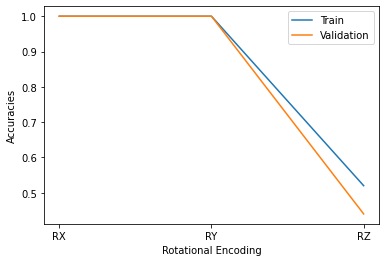

In [234]:
import matplotlib.pyplot as plt

plt.xlabel('Rotational Encoding')
plt.ylabel('Accuracies')

plt.plot(["RX","RY","RZ"], [1, 1, 0.52], label = "Train")
plt.plot(["RX","RY","RZ"], [1, 1, 0.44], label = "Validation")
plt.legend()

plt.show()

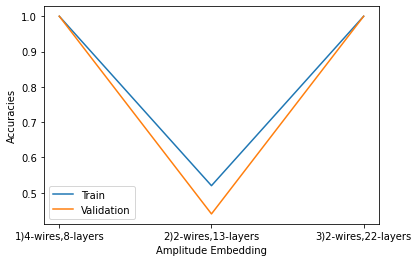

In [237]:
import matplotlib.pyplot as plt

plt.xlabel('Amplitude Embedding')
plt.ylabel('Accuracies')

plt.plot(["1)4-wires,8-layers","2)2-wires,13-layers","3)2-wires,22-layers"], [1, 0.52, 1], label = "Train")
plt.plot(["1)4-wires,8-layers","2)2-wires,13-layers","3)2-wires,22-layers"], [1, 0.44, 1], label = "Validation")
plt.legend()

plt.show()